In [2]:
import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci

root_path = Path("../")

class Args:
    model = root_path / "resources/models/1644949114.3169951/M_total/e4.pth"
    input = root_path / "resources/images/calibrated_masked/cropped/ycb_video/test_dataset.json"
    scale = 0.5

args = Args()
files = DatasetInterface.get_files_by_path(args.input)

net = UNet(n_input_channels=6, n_output_channels=1, initial_channels=8)
net = nn.DataParallel(net)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(args.model, map_location=device))
net.eval()

logging.info('Model loaded!')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/kit/anthropomatik/ng3916/.conda/envs/depth-denoising_training/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /tmp/pip-req-build-1qm6302z/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
INFO - 2022-02-15 19:39:28,044 - 3185137690 - Loading model ../resources/models/1644949114.3169951/M_total/e3.pth
INFO - 2022-02-15 19:39:28,045 - 3185137690 - Using device cpu
INFO - 2022-02-15 19:39:28,054 - 3185137690 - Model loaded!


INFO - 2022-02-15 19:39:28,381 - 59363149 - 
Predicting image /pfs/data5/home/kit/anthropomatik/ng3916/self-supervised-depth-denoising/resources/images/calibrated_masked/cropped/ycb_video/10022022/1644490456.8614383.npz ...


Mean depths: Input 1204.863566743827 Label 465.3323669433594 Predicted 0.06354621797800064
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


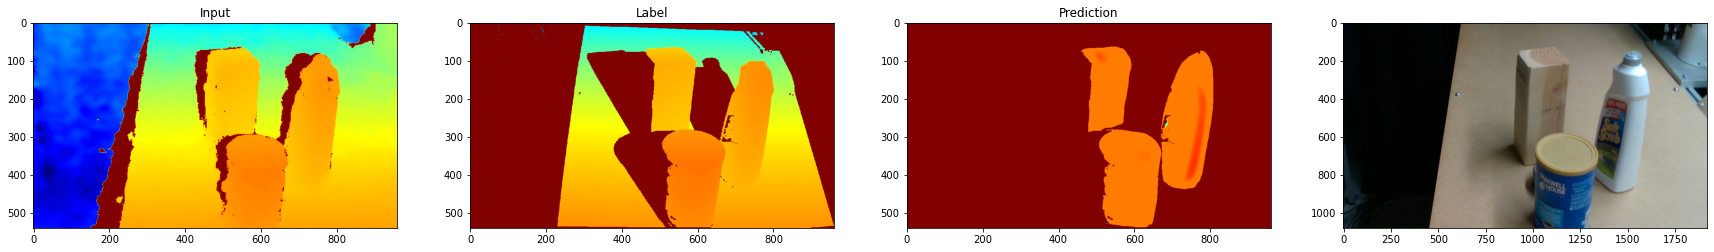

In [3]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

# crop_region_mask = np.zeros((rs_rgb.shape[:2]), dtype=np.uint8)
# crop_region_mask[:, 500:1600] = 1
# rs_rgb = rs_rgb * crop_region_mask[..., None]
# zv_rgb = zv_rgb * crop_region_mask[..., None]
# rs_depth = np.where(crop_region_mask, rs_depth, np.nan)
# zv_depth = np.where(crop_region_mask, zv_depth, np.nan)

set = BasicDataset.preprocess_set(rs_rgb, rs_depth, mask, zv_depth, dataset_config=BasicDataset.Config(add_nan_mask_to_input=True, 
    add_region_mask_to_input=True, enable_augmentation=False, normalize_depths=True, scale=0.5))
img = set['image'].unsqueeze(0)
img[0, 3] /= 1000
nan_mask = set['nan-mask']
region_mask = set['region-mask']
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

pred_depth = np.where(np.logical_and(nan_mask, region_mask)[0], pred_depth, np.nan)

input_rgb = BasicDataset.resize(rs_rgb, args.scale)
output_rgb = BasicDataset.resize(zv_rgb, args.scale)
input_depth = BasicDataset.resize(rs_depth, args.scale)
real_depth = BasicDataset.resize(zv_depth, args.scale)
depths = np.concatenate((input_depth, pred_depth, real_depth), axis=1)

real_depth = np.nan_to_num(real_depth)
input_depth = np.nan_to_num(input_depth)

print(f"Mean depths: Input {np.nanmean(input_depth)} Label {np.nanmean(real_depth)} Predicted {np.nanmean(pred_depth)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)
o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))